In [55]:
#Grzegorz Jędrzejowski 428515
print("Working?")

Working?


In [56]:
#Setting up the base path

import sys
import os

my_BDT_directory_location = '/scratch/gjedrzej/WUM1/BDT_GJ' #Full path of where your BDT_GJ directory is
sys.path.append(os.path.abspath(my_BDT_directory_location))

In [57]:
#Installing requirements

requirements_path = os.path.join(my_BDT_directory_location, 'requirements.txt')

%pip install --upgrade pip #Pip 21.3+ is required
%pip install -r {requirements_path}

#you might need to restart the kernel after installing requirements

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [58]:
#Imports 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import shap


import subscripts.readParquet as read
import subscripts.filter as filter
import subscripts.plotter as plotter

In [59]:
#Loading the data from .parquet files

Paths = [os.path.join(my_BDT_directory_location, 'Run3_2022/et/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/'),
         os.path.join(my_BDT_directory_location, 'Run3_2022/mt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/'),
         os.path.join(my_BDT_directory_location, 'Run3_2022/tt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/')]

df_et = pd.DataFrame()
df_mt = pd.DataFrame()
df_tt = pd.DataFrame()

df_et = read.read_parquet(Paths[0])
df_mt = read.read_parquet(Paths[1])
df_tt = read.read_parquet(Paths[2])

df_et_filtered = filter.apply_selection(df_et)
df_mt_filtered = filter.apply_selection(df_mt)
df_tt_filtered = filter.apply_selection(df_tt)

Found 5 files in /scratch/gjedrzej/WUM1/BDT_GJ/Run3_2022/et/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/. Loading...
✅ Successfully loaded 17468 rows.
Found 15 files in /scratch/gjedrzej/WUM1/BDT_GJ/Run3_2022/mt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/. Loading...
✅ Successfully loaded 73043 rows.
Found 5 files in /scratch/gjedrzej/WUM1/BDT_GJ/Run3_2022/tt/GluGluHTo2Tau_UncorrelatedDecay_SM_Filtered_ProdAndDecay/nominal/. Loading...
✅ Successfully loaded 20258 rows.


In [60]:
pd.set_option('display.max_columns', None)
df_et_filtered.head()


,event,run,lumi,charge_1,charge_2,pt_1,eta_1,phi_1,mass_1,pt_2,eta_2,phi_2,mass_2,os,dR,dphi,pt_tt,pt_vis,phi_vis,eta_vis,mt_1,mt_2,mt_lep,mt_tot,m_vis,met_pt,met_phi,met_covXX,met_covXY,met_covYY,met_dphi_1,met_dphi_2,trg_singleelectron,trg_et_cross,idDeepTau2018v2p5VSjet_2,idDeepTau2018v2p5VSmu_2,idDeepTau2018v2p5VSe_2,decayMode_2,decayModePNet_2,n_jets,n_bjets,mjj,jdeta,sjdphi,dijetpt,jpt_1,jeta_1,jphi_1,jpt_2,jeta_2,jphi_2,aco_e_pi,aco_e_rho,aco_e_a1_FASTMTT_MassConstraint,alphaAngle_e_pi_1,alphaAngle_e_pi_2,alphaAngle_e_rho_1,alphaAngle_e_rho_2,alphaAngle_e_a1_FASTMTT_MassConstraint_1,alphaAngle_e_a1_FASTMTT_MassConstraint_2,PV_x,PV_y,PV_z,PVBS_x,PVBS_y,PVBS_z,ip_x_1,ip_y_1,ip_z_1,ip_x_2,ip_y_2,ip_z_2,ip_LengthSig_1,ip_LengthSig_2,hasRefitSV_1,hasRefitSV_2,sv_x_1,sv_y_1,sv_z_1,sv_x_2,sv_y_2,sv_z_2,FastMTT_mass,FastMTT_pt,FastMTT_pt_1,FastMTT_pt_2,FastMTT_mass_constraint,FastMTT_pt_constraint,FastMTT_pt_1_constraint,FastMTT_pt_2_constraint,pi_pt_1,pi_eta_1,pi_phi_1,pi_mass_1,pi_charge_1,pi_pdgId_1,pi_Energy_1,pi2_pt_1,pi2_eta_1,pi2_phi_1,pi2_mass_1,pi2_charge_1,pi2_pdgId_1,pi2_Energy_1,pi3_pt_1,pi3_eta_1,pi3_phi_1,pi3_mass_1,pi3_charge_1,pi3_pdgId_1,pi3_Energy_1,pi0_pt_1,pi0_eta_1,pi0_phi_1,pi0_mass_1,pi0_charge_1,pi0_pdgId_1,pi0_Energy_1,pi_pt_2,pi_eta_2,pi_phi_2,pi_mass_2,pi_charge_2,pi_pdgId_2,pi_Energy_2,pi2_pt_2,pi2_eta_2,pi2_phi_2,pi2_mass_2,pi2_charge_2,pi2_pdgId_2,pi2_Energy_2,pi3_pt_2,pi3_eta_2,pi3_phi_2,pi3_mass_2,pi3_charge_2,pi3_pdgId_2,pi3_Energy_2,pi0_pt_2,pi0_eta_2,pi0_phi_2,pi0_mass_2,pi0_charge_2,pi0_pdgId_2,pi0_Energy_2,weight,genWeight,is_data,LHEReweightingWeight_SM,LHEReweightingWeight_PS,LHEReweightingWeight_MM,nLHEjets,npNLOjets,LHE_Vpt,wt_cp_sm,wt_cp_ps,wt_cp_mm,pion_E_split_1,pion_E_split_2,gen_boson_pT,gen_boson_mass,gen_boson_eta,gen_boson_phi,gen_taunus_pT,gen_taunus_phi,genPartFlav_1,genPartFlav_2,genPart_pt_1,genPart_eta_1,genPart_phi_1,genPart_pdgId_1,genPart_pt_2,genPart_eta_2,genPart_phi_2,genPart_pdgId_2,genVisTau_pt_1,genVisTau_eta_1,genVisTau_phi_1,genVisTau_mass_1,genVisTau_pt_2,genVisTau_eta_2,genVisTau_phi_2,genVisTau_mass_2,gen_decayMode_1,gen_decayMode_2,genIP_1_x,genIP_1_y,genIP_1_z,genIP_2_x,genIP_2_y,genIP_2_z,w_WJ_soup,w_DY_NLO_soup,iso_1,e_pass90_1,e_mva_score_1,abs_eta_1,BDT_pred_score,BDT_pred_class,BDT_raw_score_tau,BDT_raw_score_higgs,BDT_raw_score_fake
0,16391896,1,12045,-1,1,39.168385,-0.598999,-2.536133,7.539056e-07,49.778530,0.113815,0.753906,1.277344,True,3.076854,2.993146,25.183544,12.468427,1.237111,-1.217231,18.333662,85.142166,88.068680,123.860420,93.768723,37.447762,-2.052734,195.0,93.7500,125.75,-0.483398,2.806641,False,False,8,4,8,10,11,0,0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,-9999.000000,-9999.000000,5.234073,NaN,3.076385,1.206437,0.819111,1.206437,NaN,1.206437,1.327962,0.103271,-0.017334,4.415771,0.101013,-0.015076,4.414307,0.002895,-0.002549,-0.001101,0.002543,-0.003241,0.003808,1.724609,2.201172,0.0,True,-9999.0,-9999.0,-9999.0,0.300049,0.170532,4.445312,127.593847,24.438345,72.534045,49.778530,126.428674,23.184218,71.215245,49.778530,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,30.312500,0.108582,0.767456,0.139570,1,211.0,30.491687,9.781250,0.113892,0.755859,0.13957,-1,-211.0,9.845746,9.695312,0.129822,0.709351,0.13957,1,211.0,9.778124,-9999.000000,-9999.000000,-9999.000000,0.13498,0.0,111.0,-9999.000000,1.0,54.6329,0.0,1.0,0.489014,0.175438,3,157,0.0,0.880757,1.097813,0.082132,-9999.0,-9999.000000,8.170824,124.999953,-2.034641,2.141535,16.794702,-2.526153,15,5,39.5000,-0.599609,-2.539062,11.0,59.125,0.117188,0.750000,-15.0,-9999.0,-9999.0,-9999.0,-9999.0,57.125,0.118164,0.750000,1.699219,-1.0,11.0,0.003690,-0.001971,-0.003023,0.002785,-0.003024,0.000880,1.0,1.0,0.091817,True,0.999999,0.598999,0.486806,1,0.063301,0.

In [61]:
#Preparing the data for XGBoost

#0 -> et, 1 -> mt, 2 -> tt
df_et_filtered['channel'] = 0
df_mt_filtered['channel'] = 1
df_tt_filtered['channel'] = 2

features = [
    'pt_1', 'eta_1', 'phi_1', 'mass_1', 
    'pt_2', 'eta_2', 'phi_2', 'mass_2', 
    'channel', 'met_pt', 'met_phi', 
    'met_covXX', 'met_covXY', 'met_covYY', 'm_vis'
]

# targets = ['genPart_pt_1', 'genPart_pt_2']
targets = ['genPart_pt_2'] #Particle 1 may be incorrectly reconstructed based on the results

X_et = df_et_filtered[features]
Y_et = df_et_filtered[targets]

X_mt = df_mt_filtered[features]
Y_mt = df_mt_filtered[targets]

X_tt = df_tt_filtered[features]
Y_tt = df_tt_filtered[targets]

X_train_et, X_test_et, y_train_et, y_test_et = train_test_split(X_et, Y_et, test_size=0.2, random_state=42)
X_train_mt, X_test_mt, y_train_mt, y_test_mt = train_test_split(X_mt, Y_mt, test_size=0.2, random_state=42)
X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X_tt, Y_tt, test_size=0.2, random_state=42)

In [62]:
# #Running Grid Search to find the best hyperparameters for ET channel -> over 8 minutes job
#Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 300, 'subsample': 0.9}
#Overfitting is the main issue
param_grid = {
    # 'arange' for integers, 'linspace' for floats
    'max_depth': np.arange(3, 10, 1),              
    'learning_rate': [0.02, 0.05, 0.1],          
    'n_estimators': [300, 500, 1000],        
    'subsample': [0.75, 0.9],     
    'colsample_bytree': [0.7, 0.9]
}

xgb_model = xgb.XGBRegressor(objective='reg:absoluteerror', tree_method='hist')


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,              
    scoring='neg_mean_absolute_error',
    verbose=2,         #debug messages
    n_jobs=-1          #All CPUs
)

# grid_search.fit(X_train_et, y_train_et)
# print(f"Best Parameters: {grid_search.best_params_}")


[0]	validation_0-mae:42.64314	validation_1-mae:27.23386
[100]	validation_0-mae:35.15349	validation_1-mae:20.70743
[200]	validation_0-mae:34.39718	validation_1-mae:20.50925
[299]	validation_0-mae:34.06735	validation_1-mae:20.37113


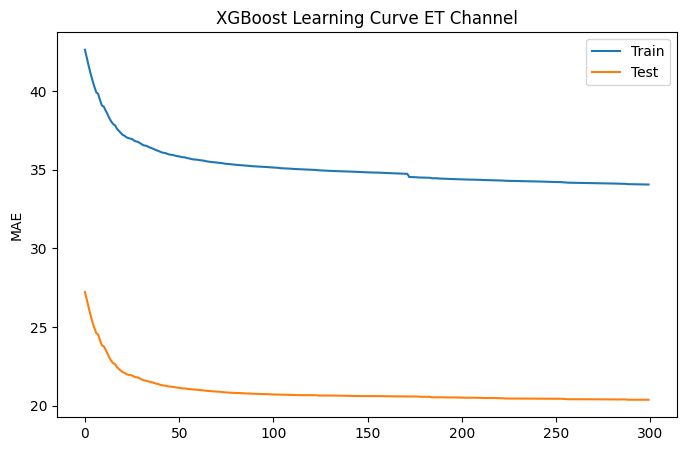

In [63]:
#Training Tree for the ET Channel

#Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 300, 'subsample': 0.9}

# Use a dictionary with curly braces
best_params_et = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'tree_method': 'hist',     
    'objective': 'reg:absoluteerror'
}

# Initialize using the double asterisk ** to unpack the dictionary
model_et = xgb.XGBRegressor(**best_params_et)
# model_et = xgb.XGBRegressor(**grid_search.best_params_) #unpacks params

# Now fit it to see your final results
model_et.fit(
    X_train_et, 
    y_train_et,
    eval_set=[(X_train_et, y_train_et), (X_test_et, y_test_et)],
    verbose=100
)



results = model_et.evals_result()

# Extract the loss values
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost Learning Curve ET Channel')
plt.show()


In [64]:
#Running Grid Search to find the best hyperparameters for MT channel -> over 17 minutes job
#Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 500, 'subsample': 0.75}

# grid_search.fit(X_train_mt, y_train_mt)
# print(f"Best Parameters: {grid_search.best_params_}")


[0]	validation_0-mae:39.93237	validation_1-mae:35.84867
[100]	validation_0-mae:33.09298	validation_1-mae:29.04016
[200]	validation_0-mae:32.66188	validation_1-mae:29.01599
[300]	validation_0-mae:32.37787	validation_1-mae:28.78926
[400]	validation_0-mae:32.16088	validation_1-mae:28.61560
[499]	validation_0-mae:31.98589	validation_1-mae:28.49253


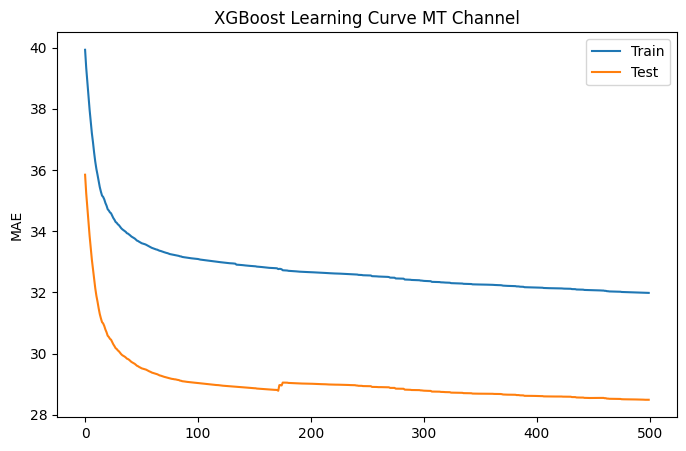

In [65]:
#Training Tree for the MT Channel

#Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 500, 'subsample': 0.75}
best_params_mt = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'subsample': 0.75,
    'colsample_bytree': 0.9,
    'tree_method': 'hist',      
    'objective': 'reg:absoluteerror'
}

# model_mt = xgb.XGBRegressor(**grid_search.best_params_) #unpacks params
model_mt = xgb.XGBRegressor(**best_params_mt) #unpacks params

model_mt.fit(
    X_train_mt, 
    y_train_mt, 
    eval_set=[(X_train_mt, y_train_mt), (X_test_mt, y_test_mt)], 
    verbose=100
)

results = model_mt.evals_result()

# Extract the loss values
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost Learning Curve MT Channel')
plt.show()

In [66]:
#Running Grid Search to find the best hyperparameters for TT channel -> over 9 minutes job
#Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 500, 'subsample': 0.75}

# grid_search.fit(X_train_tt, y_train_tt)
# print(f"Best Parameters: {grid_search.best_params_}")


[0]	validation_0-mae:29.29674	validation_1-mae:25.12592
[100]	validation_0-mae:24.30459	validation_1-mae:20.52080
[200]	validation_0-mae:23.90187	validation_1-mae:20.30853
[300]	validation_0-mae:23.66393	validation_1-mae:20.23996
[400]	validation_0-mae:23.48502	validation_1-mae:20.20765
[499]	validation_0-mae:23.35506	validation_1-mae:20.19842


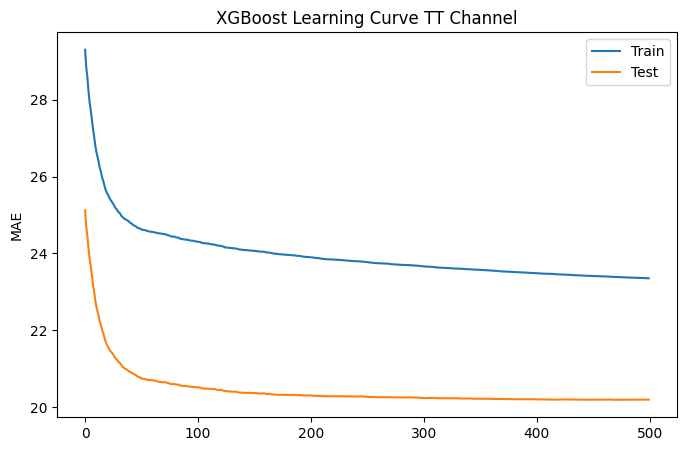

In [67]:
#Training Tree for the TT Channel

#Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 500, 'subsample': 0.75}
best_params_tt = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'subsample': 0.75,
    'colsample_bytree': 0.9,
    'tree_method': 'hist',      
    'objective': 'reg:absoluteerror',
    #Fighting overfitting
    # 'gamma': 10, 
    # 'reg_alpha': 0.5,            
    # 'reg_lambda': 1.5          
}

# model_tt = xgb.XGBRegressor(**grid_search.best_params_) #unpacks params
model_tt = xgb.XGBRegressor(**best_params_tt) #unpacks params

model_tt.fit(
    X_train_tt, 
    y_train_tt, 
    eval_set=[(X_train_tt, y_train_tt), (X_test_tt, y_test_tt)], 
    verbose=100
)

results = model_tt.evals_result()
# Extract the loss values
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost Learning Curve TT Channel')
plt.show()

<Axes: title={'center': 'TT'}, xlabel='F score', ylabel='Features'>

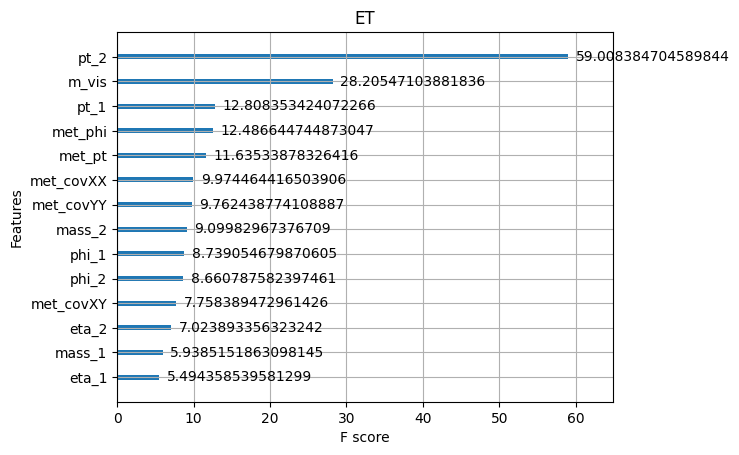

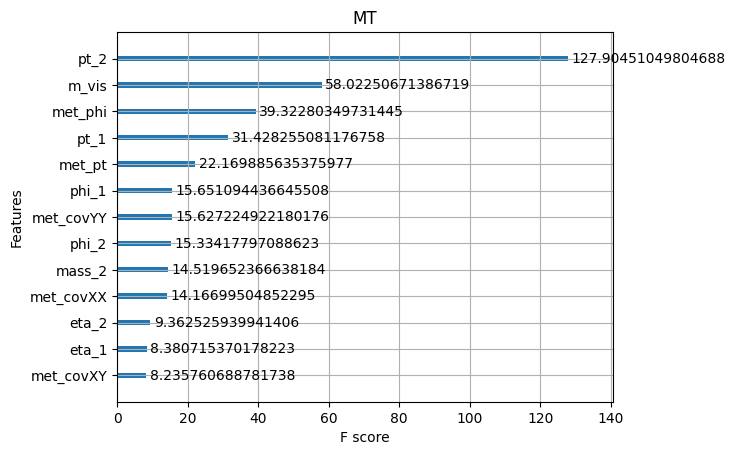

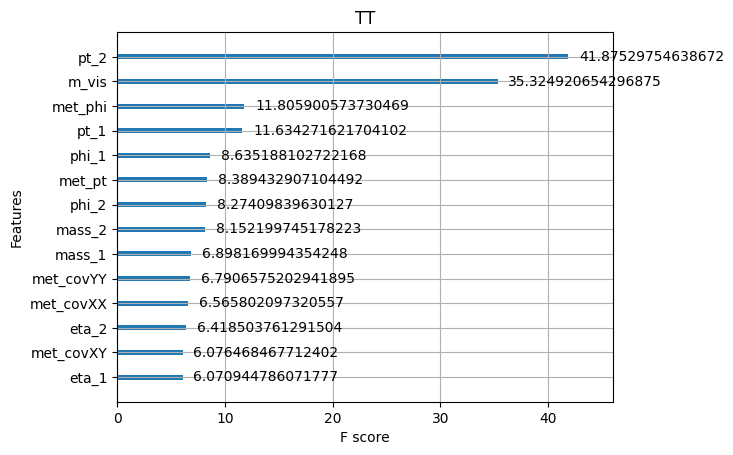

In [68]:
# Features evaluation
xgb.plot_importance(model_et, importance_type='gain', title='ET')
xgb.plot_importance(model_mt, importance_type='gain', title='MT')
xgb.plot_importance(model_tt, importance_type='gain', title='TT')

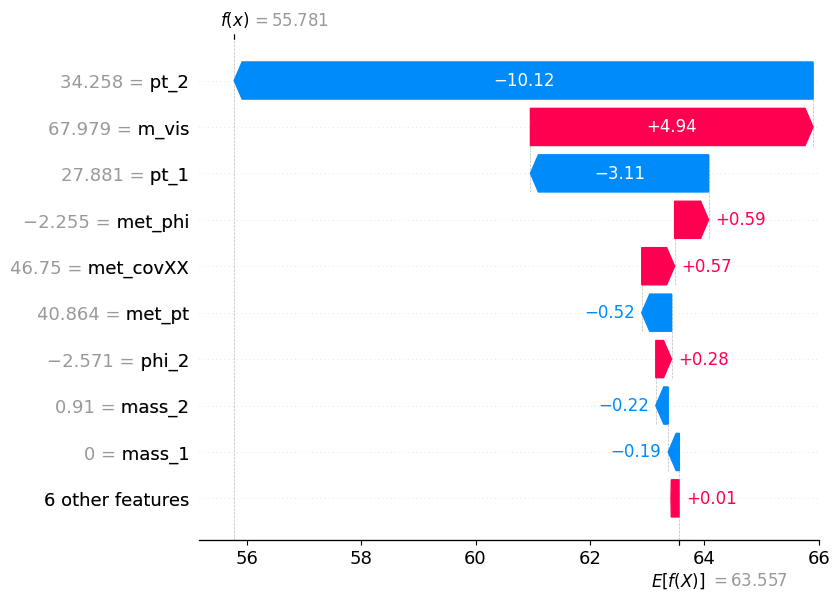

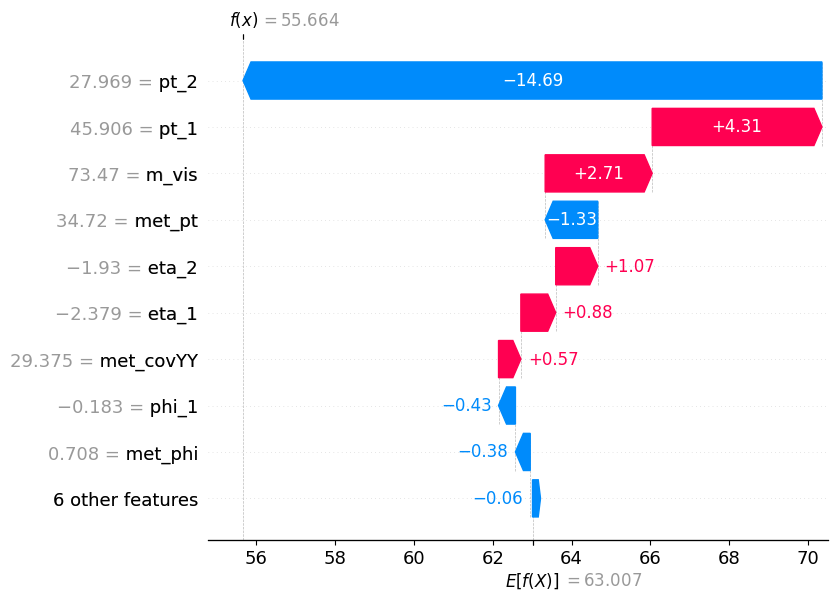

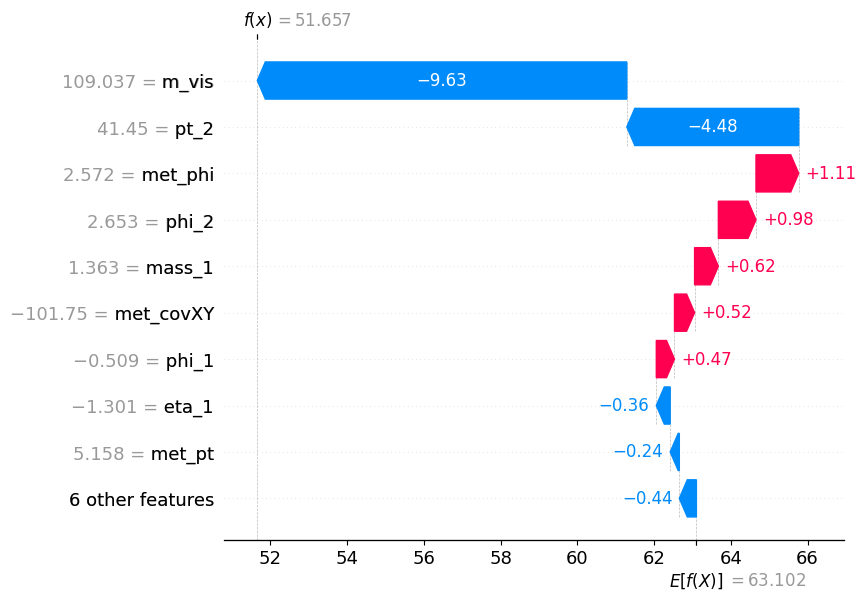

In [ ]:
#Shapley values for explaining tree decision
explainer_et = shap.TreeExplainer(model_et)
shap_values_et = explainer_et(X_test_et)
shap.plots.waterfall(shap_values_et[0])

explainer_mt = shap.TreeExplainer(model_mt)
shap_values_mt = explainer_mt(X_test_mt)
shap.plots.waterfall(shap_values_mt[0])

explainer_tt = shap.TreeExplainer(model_tt)
shap_values_tt = explainer_tt(X_test_tt)
shap.plots.waterfall(shap_values_tt[0])

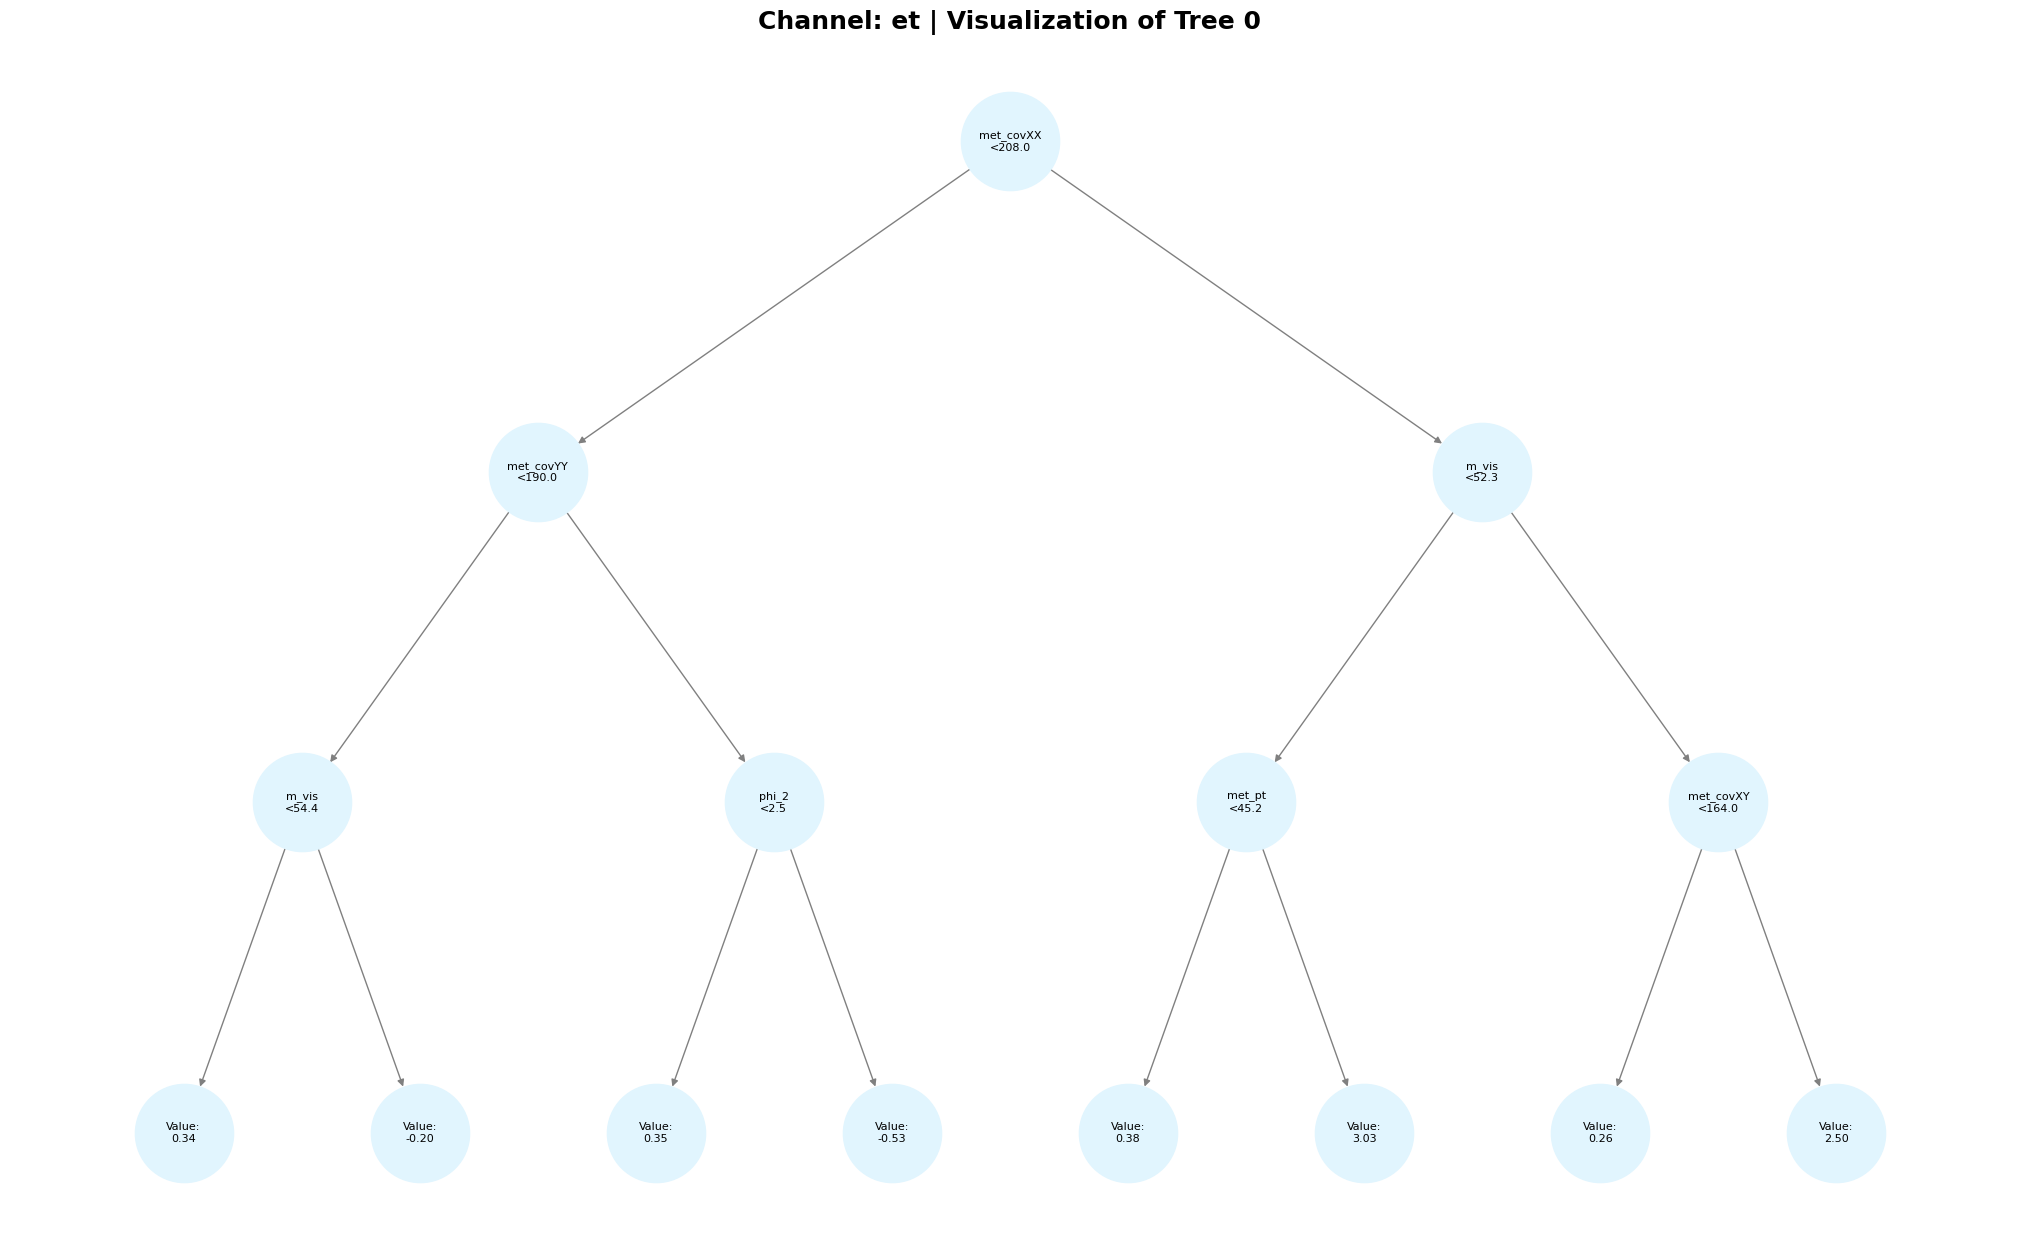

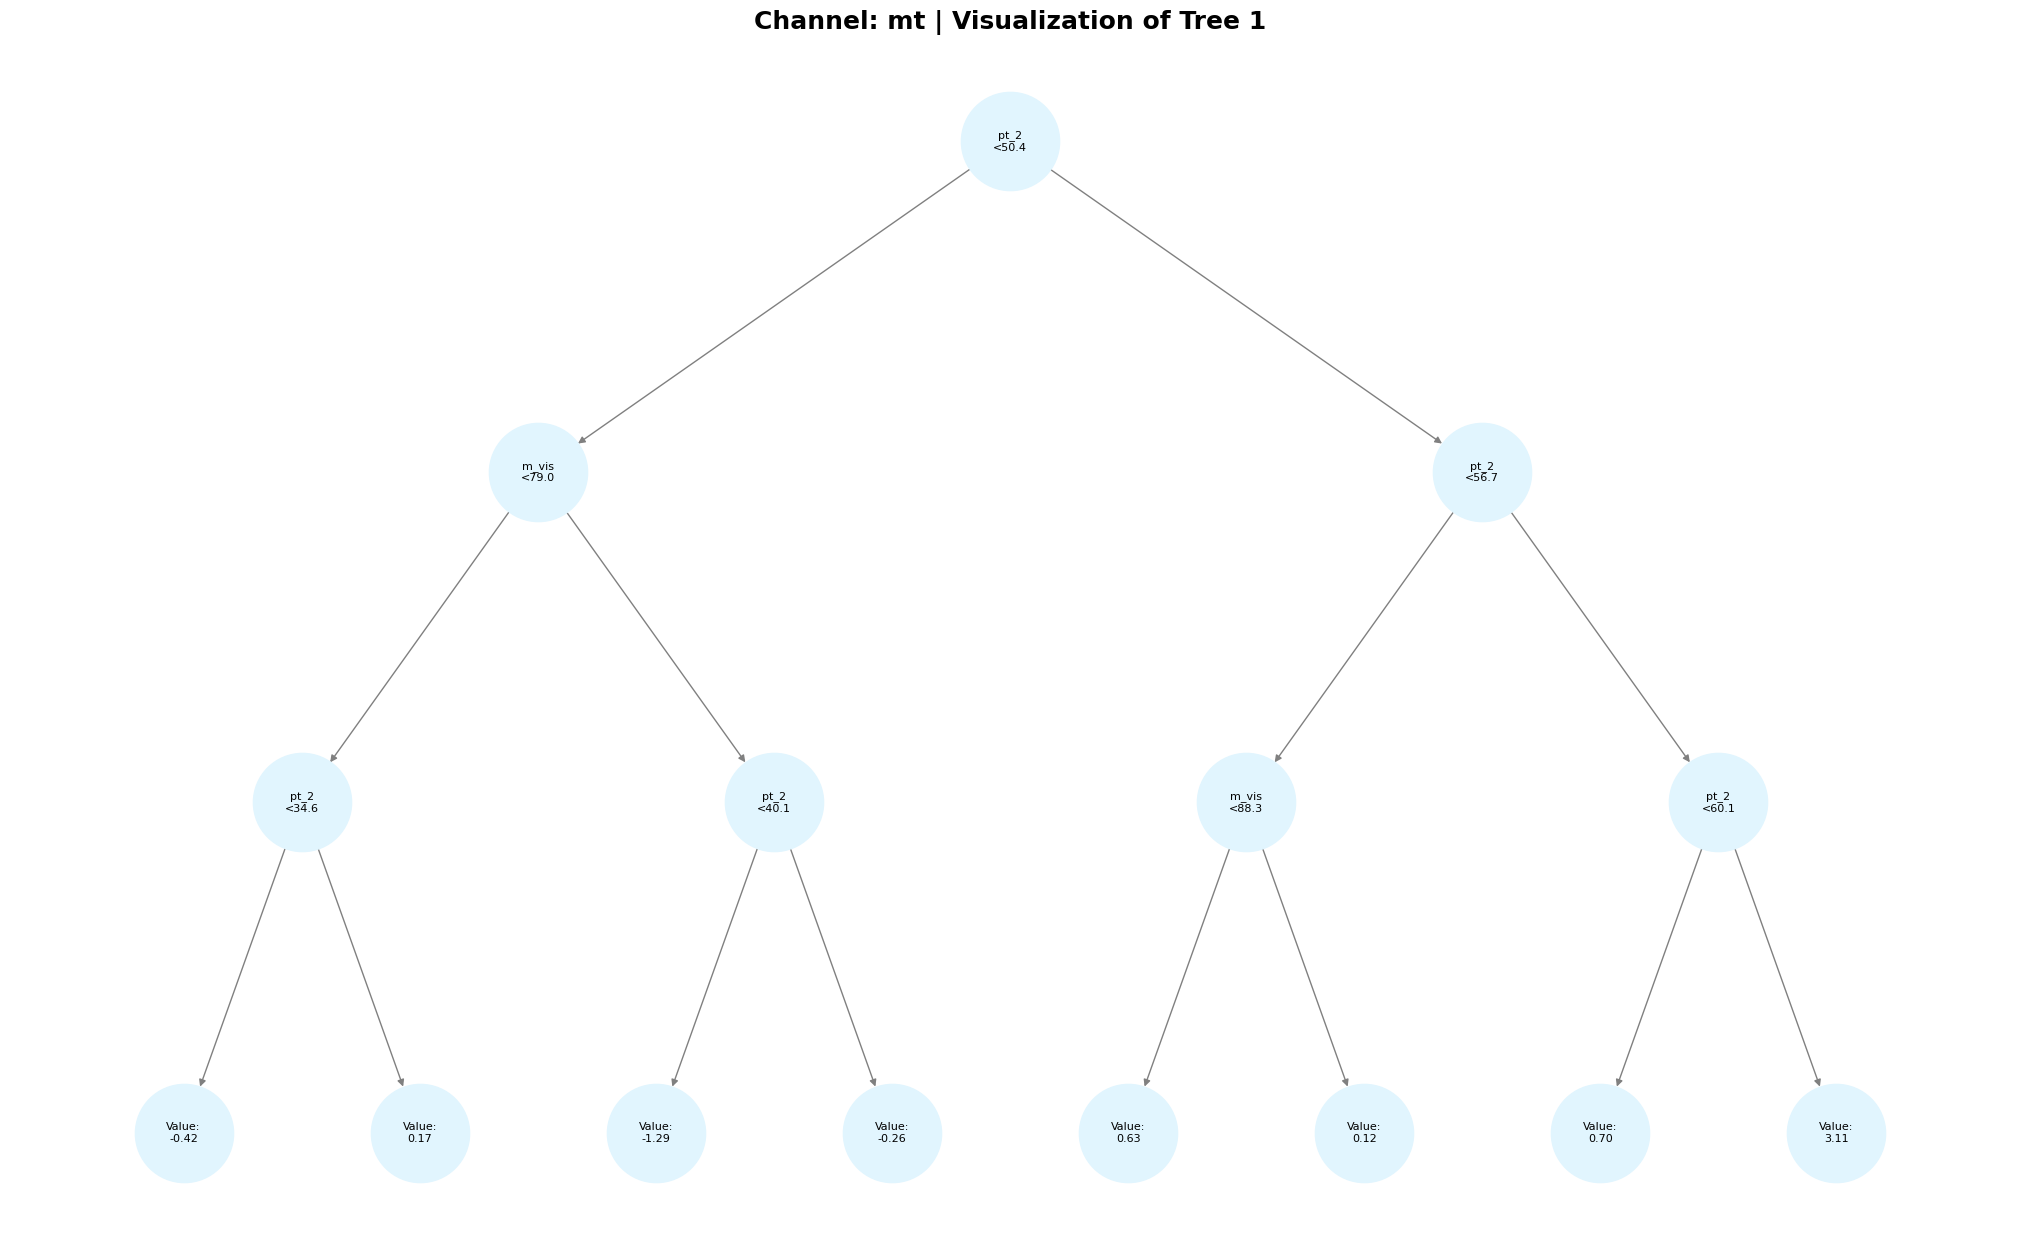

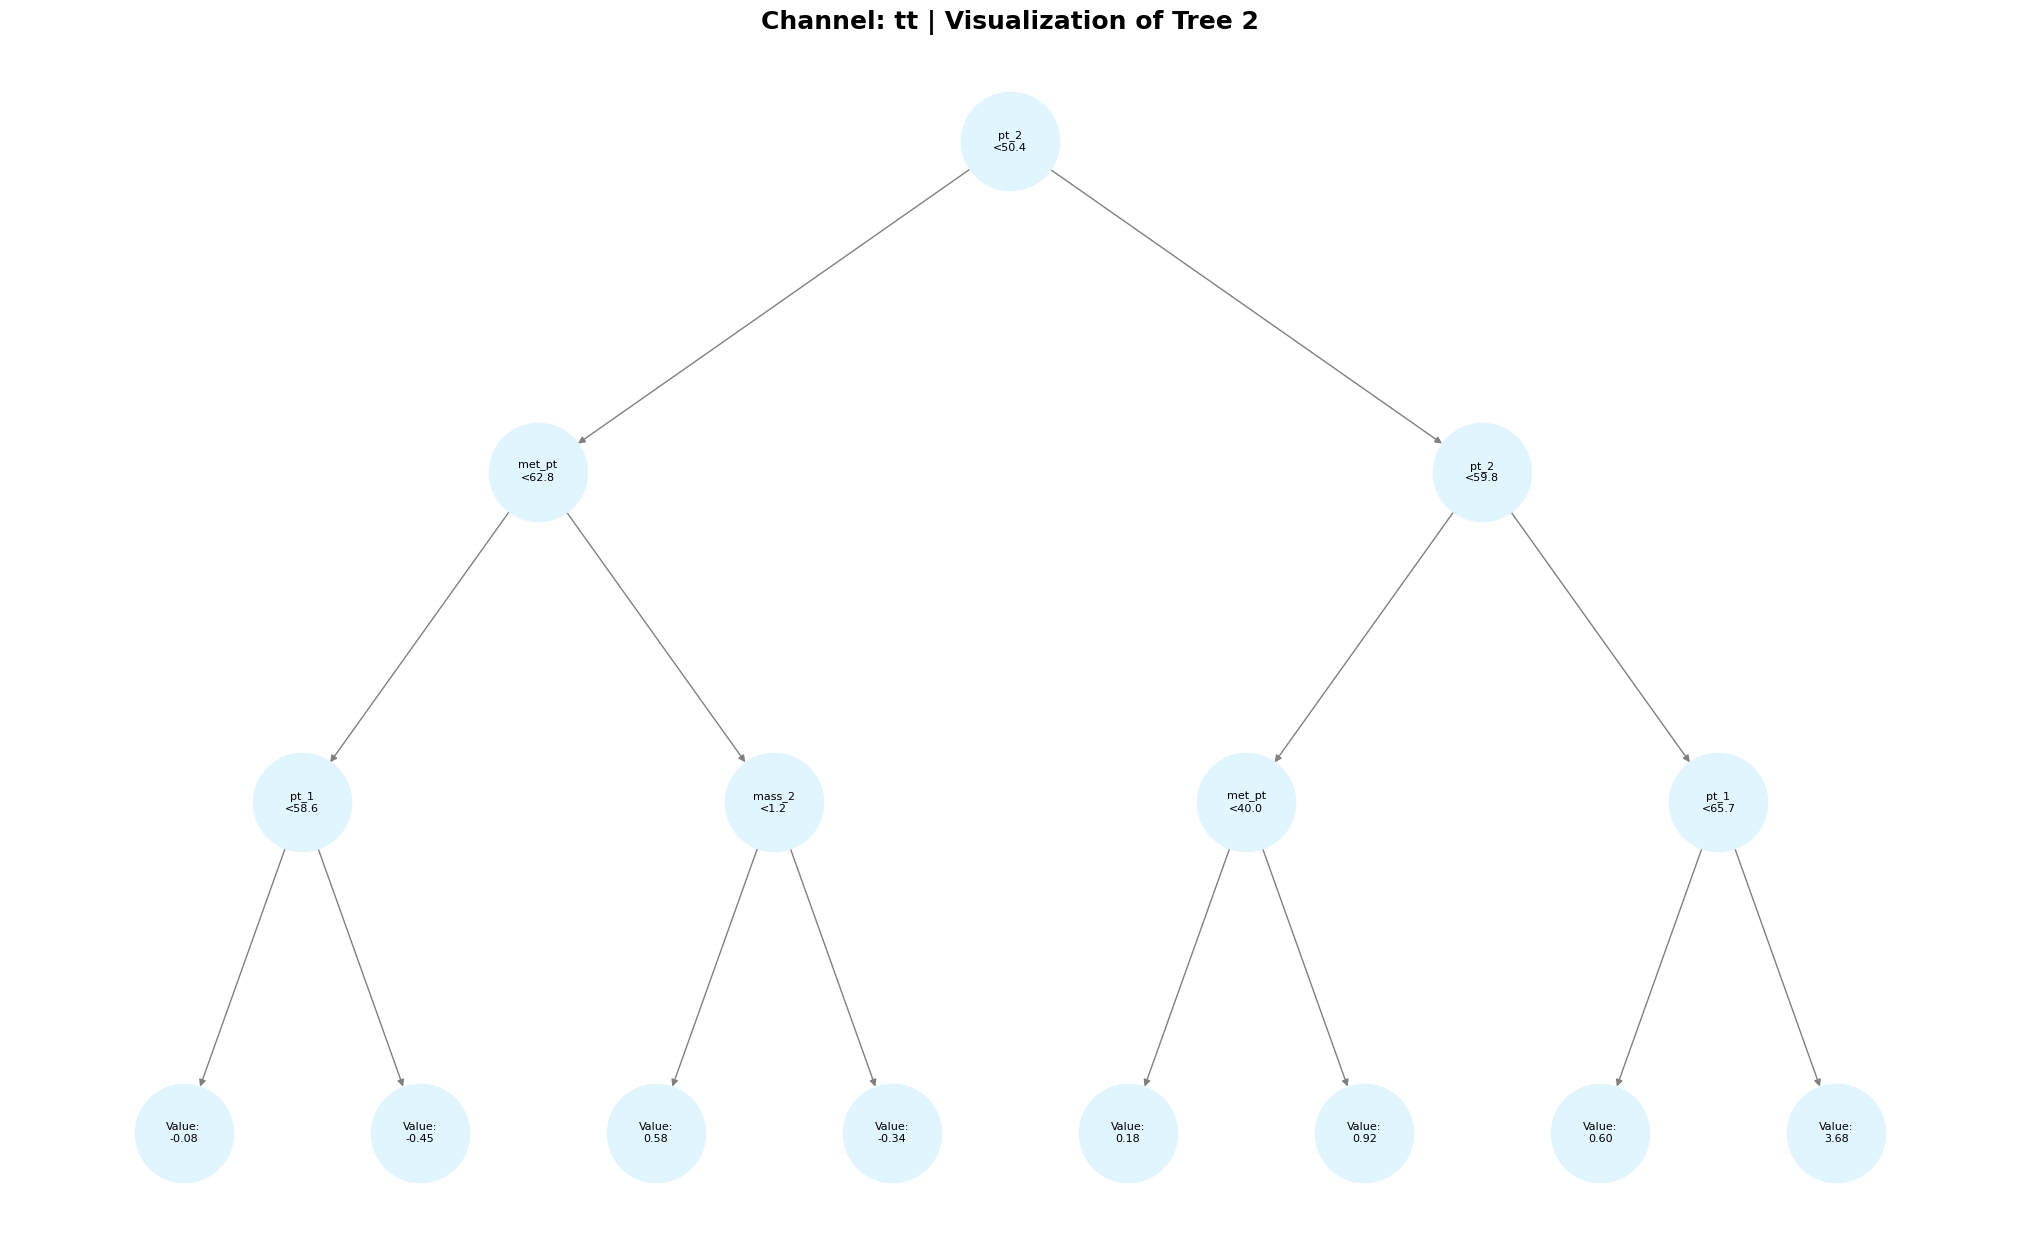

In [70]:
#Displaying trees

plotter.plot_clean_tree(model_et, tree_idx=0)
plotter.plot_clean_tree(model_mt, tree_idx=1)
plotter.plot_clean_tree(model_tt, tree_idx=2)

Saving plot to: /scratch/gjedrzej/WUM1/BDT_GJ/plots/True_vs_Pred_ET.png


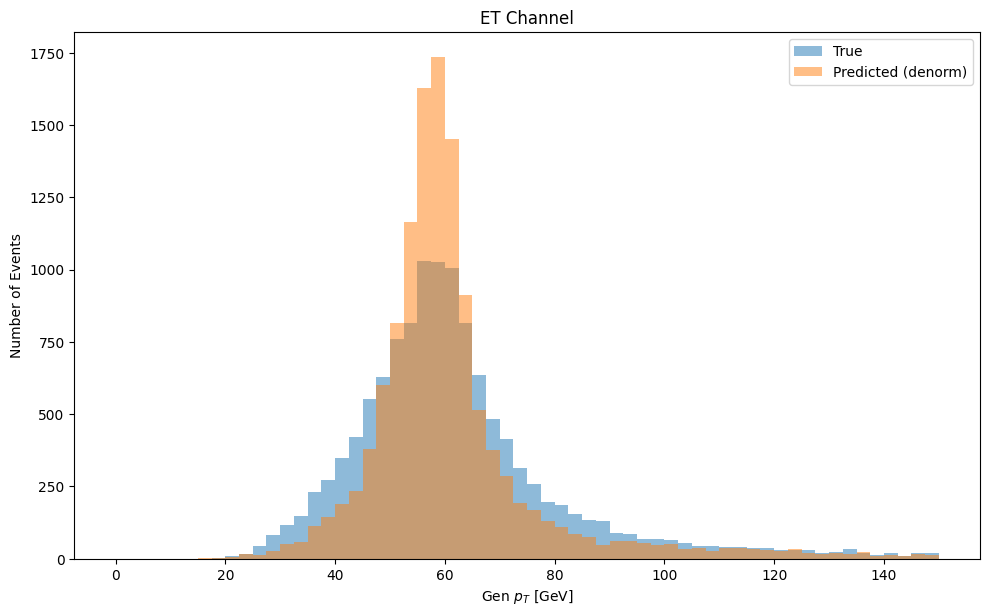

Saving plot to: /scratch/gjedrzej/WUM1/BDT_GJ/plots/True_vs_Pred_MT.png


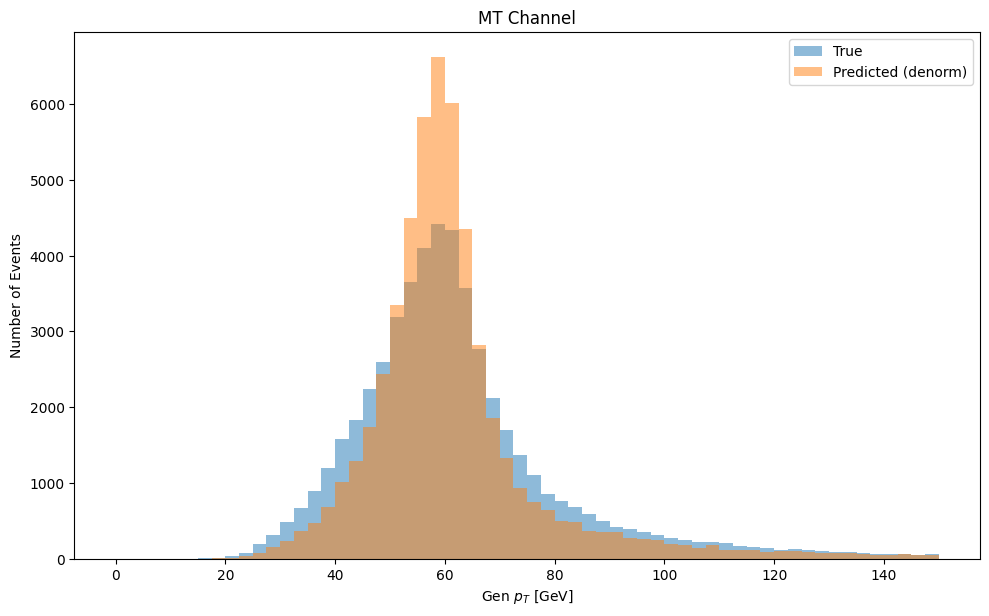

Saving plot to: /scratch/gjedrzej/WUM1/BDT_GJ/plots/True_vs_Pred_TT.png


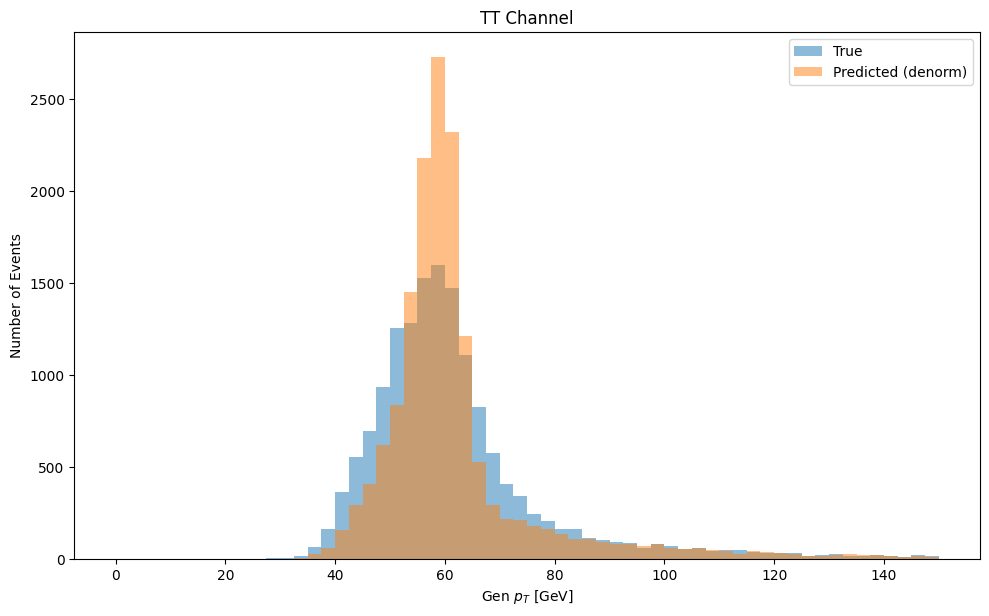

In [71]:
#Calling HEP plotting function to compare true vs predicted pT

#Plotter accepts 2D arrays
y_true_2d = Y_et.to_numpy().reshape(-1, 1)
y_pred_2d = model_et.predict(X_et).reshape(-1, 1)

plotter.plot_histogram_comparison(
    y_arr = y_true_2d,             
    preds_arr = y_pred_2d,   
    dim_idx = 0,               # Use 0 for the first (and only) column
    range_vals = (0, 150),
    output_path = os.path.join(my_BDT_directory_location, 'plots/True_vs_Pred_ET.png')
)

ax = plt.gca()
ax.set_title("ET Channel")
ax.set_xlabel("Gen $p_T$ [GeV]")
ax.set_ylabel("Number of Events")
plt.show()

y_true_2d = Y_mt.to_numpy().reshape(-1, 1)
y_pred_2d = model_mt.predict(X_mt).reshape(-1, 1)

plotter.plot_histogram_comparison(
    y_arr = y_true_2d,             
    preds_arr = y_pred_2d,
    dim_idx = 0,               # Use 0 for the first (and only) column
    range_vals = (0, 150),
    output_path = os.path.join(my_BDT_directory_location, 'plots/True_vs_Pred_MT.png')
)

ax = plt.gca()
ax.set_title("MT Channel")
ax.set_xlabel("Gen $p_T$ [GeV]")
ax.set_ylabel("Number of Events")
plt.show()

y_true_2d = Y_tt.to_numpy().reshape(-1, 1)
y_pred_2d = model_tt.predict(X_tt).reshape(-1, 1)

plotter.plot_histogram_comparison(
    y_arr = y_true_2d,             
    preds_arr = y_pred_2d,
    dim_idx = 0,               # Use 0 for the first (and only) column
    range_vals = (0, 150),
    output_path = os.path.join(my_BDT_directory_location, 'plots/True_vs_Pred_TT.png')
)
ax = plt.gca()
ax.set_title("TT Channel")
ax.set_xlabel("Gen $p_T$ [GeV]")
ax.set_ylabel("Number of Events")
plt.show()



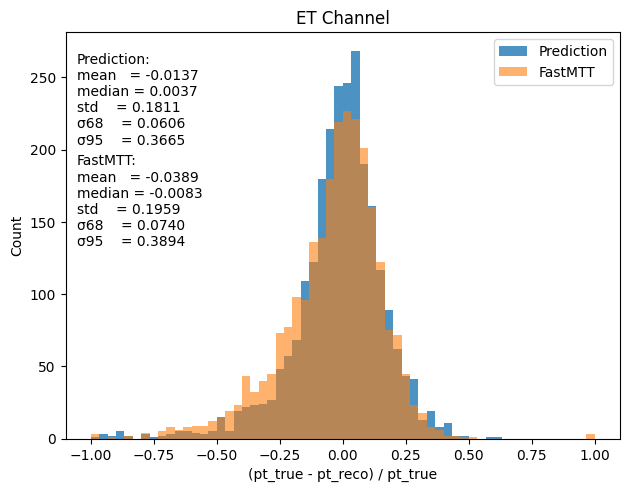

In [ ]:
#Calling HEP plotting function to compare model prediction and FastMTT reconstruction

#ET
test_idx = X_test_et.index
y_true_test = Y_et.loc[test_idx].to_numpy().reshape(-1, 1)
y_pred_test = model_et.predict(X_test_et).reshape(-1, 1)

# fastmtt_series = df_et_filtered.loc[test_idx, 'FastMTT_pt_2']
fastmtt_series = df_et_filtered.loc[test_idx, 'FastMTT_pt_2_constraint']
reco_comparison = pd.DataFrame({'FastMTT': fastmtt_series.to_numpy() })


plotter.plot_resolution(
    y_arr = y_true_test,
    preds_arr = y_pred_test,
    dim_idx = 0,               # Index 0 for single target
    range_vals = (-1.0, 1.0),
    output_path = os.path.join(my_BDT_directory_location, 'plots/resolution_ET.png'),
    reco_df = reco_comparison,  
    title="ET Channel"
)

#MT
test_idx = X_test_mt.index
y_true_test = Y_mt.loc[test_idx].to_numpy().reshape(-1, 1)
y_pred_test = model_mt.predict(X_test_mt).reshape(-1, 1)

# fastmtt_series = df_mt_filtered.loc[test_idx, 'FastMTT_pt_2']
fastmtt_series = df_mt_filtered.loc[test_idx, 'FastMTT_pt_2_constraint']
reco_comparison = pd.DataFrame({'FastMTT': fastmtt_series.to_numpy() })

plotter.plot_resolution(
    y_arr = y_true_test,
    preds_arr = y_pred_test,
    dim_idx = 0,               # Index 0 for single target
    range_vals = (-1.0, 1.0),
    output_path = os.path.join(my_BDT_directory_location, 'plots/resolution_MT.png'),
    reco_df = reco_comparison,  
    title="MT Channel"
)

#TT
test_idx = X_test_tt.index
y_true_test = Y_tt.loc[test_idx].to_numpy().reshape(-1, 1)
y_pred_test = model_tt.predict(X_test_tt).reshape(-1, 1)

# fastmtt_series = df_tt_filtered.loc[test_idx, 'FastMTT_pt_2']
fastmtt_series = df_tt_filtered.loc[test_idx, 'FastMTT_pt_2_constraint']
reco_comparison = pd.DataFrame({'FastMTT': fastmtt_series.to_numpy() })

plotter.plot_resolution(
    y_arr = y_true_test,
    preds_arr = y_pred_test,
    dim_idx = 0,               # Index 0 for single target
    range_vals = (-1.0, 1.0),
    output_path = os.path.join(my_BDT_directory_location, 'plots/resolution_TT.png'),
    reco_df = reco_comparison,  
    title="TT Channel"
)
